# Home assignment 2

### Deadline: 8th January, 2025 at 23:59 CET

### Name & Student No.:
- Abdel Kader, Schehat & 10064822
- Tarbouch, Johny & 10033994
- Asfari, Mustafa & 10075209

**1 DCGAN [45 points]**
- DCGANs have been introduced in the lecture. Explain the DCGAN architecture and their role
in image synthesis (1 paragraph)

**Answer**

- DCGANs are an extension of the GAN architecture that uses convolutional networks instead of fully connected layers to capture spatial information, leading to more realistic images. 
- The generator takes a latent vector from a standard normal distribution, e.g. 100-dimension and applies convolutional transpose operations for upsampling the latent vector to the desired volume & image size as the output. For efficient training and stability, batch normalization and ReLU activiation function are applied except for the last layer which uses Tanh
- The discriminator applies convolution layers for down sampling. In addition, batch normalization with LeakyReLU activation except for the last layer which uses Sigmoid activation. Sigmoid is used to output a probability for being a real or fake images

**1.1 Data Loading and Preprocessing**
- The dataset for this assignment is Fashion-MNIST, a collection of Zalando’s article images. The dataset can be accessed via the torchvision.datasets module. In case of problems with training time and computation, it is fine to work on a subset of Fashion-MNIST.
- Implement a data loading pipeline for DCGAN training. Preprocess the data (normalize) and prepare it for DCGAN.
- Visualize some samples of different classes of the dataset to get familiar with the data, format, and dimensions.

In [1]:
# import shutil

# # Specify the directory to delete
# dir_to_delete = '/kaggle/working/runs'

# # Delete the directory and all its contents
# shutil.rmtree(dir_to_delete)

In [5]:
# file_to_delete = '/kaggle/working/runs.tar.gz'
# os.remove(file_to_delete)

In [4]:
# import os
# import shutil

# folder_name = "runs"
# output_filename = "runs.zip"

# shutil.make_archive(f"/kaggle/working/{output_filename.split('.')[0]}", "zip", f"/kaggle/working/{folder_name}")

'/kaggle/working/runs.zip'

dataset length: 60000
image shape: torch.Size([1, 28, 28])
label: 9


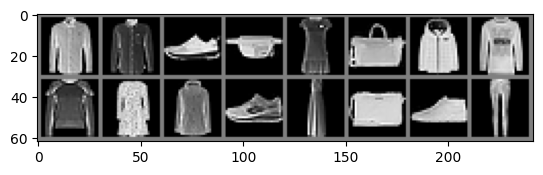

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transformation: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion-MNIST dataset
dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Data information
print(f"dataset length: {len(dataset)}")
print(f"image shape: {dataset[0][0].shape}")
print(f"label: {dataset[0][1]}")

# Create a subset of the dataset for testing
# subset_indices = list(range(1000))
# subset = torch.utils.data.Subset(dataset, subset_indices)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Visualize some samples of different classes
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:16]))

**1.2 DCGAN Architecture**
- Design the DCGAN architecture for image synthesis to generate new images similar to the Fashion-MNIST dataset.
- Implement the generator and discriminator architectures of the DCGAN architecture.
- Discuss the rationale behind your design choices.

**Answer**

**Architecture**
- Design of the DCGAN Architecture is inspired from this tutorial https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

**Generator**
- Input is a 100-dimensional latent vector and output is a 28x28 grayscale image
- Consists of 4 ConvTranspose2d layers, each followed by BatchNorm2d and ReLU activation functions. Except for the last layer which uses Tanh activation to output values in the range [-1, 1]
- The ConvTranspose2d layers upsample the latent vector until it has the desired image size

**Discriminator**
- Input is a 28x28 grayscale image and outputs is a scalar representing the probability that the input image is real
- Consists of 4 Conv2d layers, each followed by BatchNorm2d and LeakyReLU activation functions. Except for the last layer which uses Sigmoid activation to output a probability 
- The Conv2d layers downsample the image until it is a scalar value

In [3]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input: (100, 1, 1)
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # output: (256, 4, 4)

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # output: (128, 8, 8)
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # output: (64, 16, 16)
            
            nn.ConvTranspose2d(64, 1, 4, 2, 3, bias=False),
            nn.Tanh()
            # output: (1, 28, 28)
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input: (1, 28, 28)
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),              
            nn.LeakyReLU(0.2, inplace=True),
            # output: (64, 14, 14)
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),            
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # output: (128, 7, 7)
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),           
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # output: (256, 3, 3)
            
            nn.Conv2d(256, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
            # output: (1, 1, 1)
        )

    def forward(self, input):
        return self.main(input)

G = Generator().to(device)
D = Discriminator().to(device)

print(G)
print(D)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4)

**Test generator and discriminator forwarding**

In [4]:
# Generator
G = Generator().to(device)
batch_size = 64
noise = torch.randn(batch_size, 100, 1, 1, device=device)
generated_images = G(noise)
print("Shape of generator output:", generated_images.shape)

# Discriminator
discriminator = Discriminator().to(device)
output_tensor = discriminator(generated_images)
print("Shape of discriminator output:", output_tensor.shape)

Shape of generator output: torch.Size([64, 1, 28, 28])
Shape of discriminator output: torch.Size([64, 1, 1, 1])


**1.3 Training**
- Try to find the best initialization of the weight parameters and check if it affects the training procedure.
- Implement the training loop for DCGAN and train the model.
- Explain the adversarial loss used to train a GAN.
- Include a mechanism for monitoring the training progress using Tensorboard2. (1) Plot the losses of generator and discriminator versus training iterations. (2) Visualize the generator’s output on a batch of fixed noise for each epoch.
- Take screenshots of the outputs and plots generated by Tensorboard and upload them with your submission.

**Answer**

**Implementation**
- Like the design, the implementation and hyperparameters done with help of this tutorial which also uses the same parameters as in the original paper: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

**Initialization**
- The model initial weights should be randomly initialized from a normal distribution with mean=0, stdev=0.02 say authors from the original DCGAN paper 
- Here the implementation is like in the referenced tutorial

**Loss in training explanation**

**Setup**
- Optimizer Adam with lr = 0.0002 and Beta1 = 0.5 for D and G
- To monitor the progress of the G generate a fixed batch of latent vectors (fixed noise) which will be used in the training loop

**Loss Function**
- Original formula \
$
\min_G \max_D \, \mathbb{E}{x \sim p{\text{data}}(x)}[\log D(x)] + \mathbb{E}{z \sim p{z}(z)}[\log(1 - D(G(z)))]
$
- For D the loss consists of 2 parts, the prediction of D over the real images and the prediction of D over the fake images. D tries to maximize the loss by assigning the correct label to the real and fake images. This means for D, ideally the first part is 1 and the second part is 0
- By putting a minus in front of the original loss of D, it is the same as minimizing the BCE
- For G the loss only consists of the 2. part, but we rather want to maximize log(D(G(z))) because of vanishing gradient in the beginning
  
**Training loop**
- Consists of 2 parts, 1. part for updating D and the second part for updating G
- First part: When updating D, G is fixed and we update by stochastic gradient ascend. It will create a batch of real images from the training and updates. Then create a batch of fakes images from the generator and update
- Second part: When updating G, D is fixed and we update by stochastic gradient descend. Because we changed the original loss to fix vanishing gradient, the generator output from part 1 for D is used to compute the loss and update G

In [5]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply the weights_init function to randomly initialize all weights
G.apply(weights_init)
D.apply(weights_init)

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

criterion = nn.BCELoss()

optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 5
writer = SummaryWriter()

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = D(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = G(noise)
        label.fill_(fake_label)
        output = D(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)
        output = D(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item()} Loss_G: {errG.item()} D(x): {D_x} D(G(z)): {D_G_z1}/{D_G_z2}')

        # Save losses for Tensorboard
        writer.add_scalar('Loss/Discriminator', errD.item(), epoch * len(dataloader) + i)
        writer.add_scalar('Loss/Generator', errG.item(), epoch * len(dataloader) + i)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (i % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_grid = torchvision.utils.make_grid(fake, padding=2, normalize=True)
            writer.add_image('Generated Images', img_grid, epoch * len(dataloader) + i)

writer.flush()
writer.close()

# Save the trained models
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')

[0/5][0/938] Loss_D: 1.5670099258422852 Loss_G: 1.2917959690093994 D(x): 0.49888354539871216 D(G(z)): 0.5400594472885132/0.29723799228668213
[0/5][50/938] Loss_D: 0.40840473771095276 Loss_G: 3.739884376525879 D(x): 0.8337557315826416 D(G(z)): 0.16322176158428192/0.03562306612730026
[0/5][100/938] Loss_D: 0.7138893604278564 Loss_G: 4.86287260055542 D(x): 0.9253916144371033 D(G(z)): 0.438490092754364/0.012509874068200588
[0/5][150/938] Loss_D: 0.22720828652381897 Loss_G: 3.7688798904418945 D(x): 0.9419671297073364 D(G(z)): 0.1426052451133728/0.031730592250823975
[0/5][200/938] Loss_D: 0.36048662662506104 Loss_G: 3.031963348388672 D(x): 0.8836307525634766 D(G(z)): 0.18182329833507538/0.06913959980010986
[0/5][250/938] Loss_D: 0.19280946254730225 Loss_G: 3.9086108207702637 D(x): 0.949557900428772 D(G(z)): 0.12283425033092499/0.028735756874084473
[0/5][300/938] Loss_D: 0.20182013511657715 Loss_G: 3.417879104614258 D(x): 0.9392764568328857 D(G(z)): 0.12017418444156647/0.05039307847619057
[0/

In [6]:
# Load the models
# G = Generator().to(device)
# D = Discriminator().to(device)

# G.load_state_dict(torch.load('generator.pth'))
# D.load_state_dict(torch.load('discriminator.pth'))

# G.eval()
# D.eval()

In [7]:
import tensorboard
%reload_ext tensorboard
%tensorboard --logdir=runs

**1.4 Evaluation**
- Qualitatively evaluate the generative performance of your DCGAN by visualizing some of the newly generated samples.
- Address any challenges you encountered during training.

**Answer**

**Observations**

Discriminator Loss
- starts low and increases significantly during the early iterations. Afterward, it fluctuates around higher values
- Indicates that the discriminator struggled after the early stages to distinguish between real and fake images as the generator improves

**Generator Loss**
- Typically, high initial generator loss. The decreasing trend shows that it improves over time.
- Still high fluctuations in the loss, suggest instability. At worse mode collapse, but the plotted images (further below) show that the generator can generate relatively good images from different classes but some better than others  

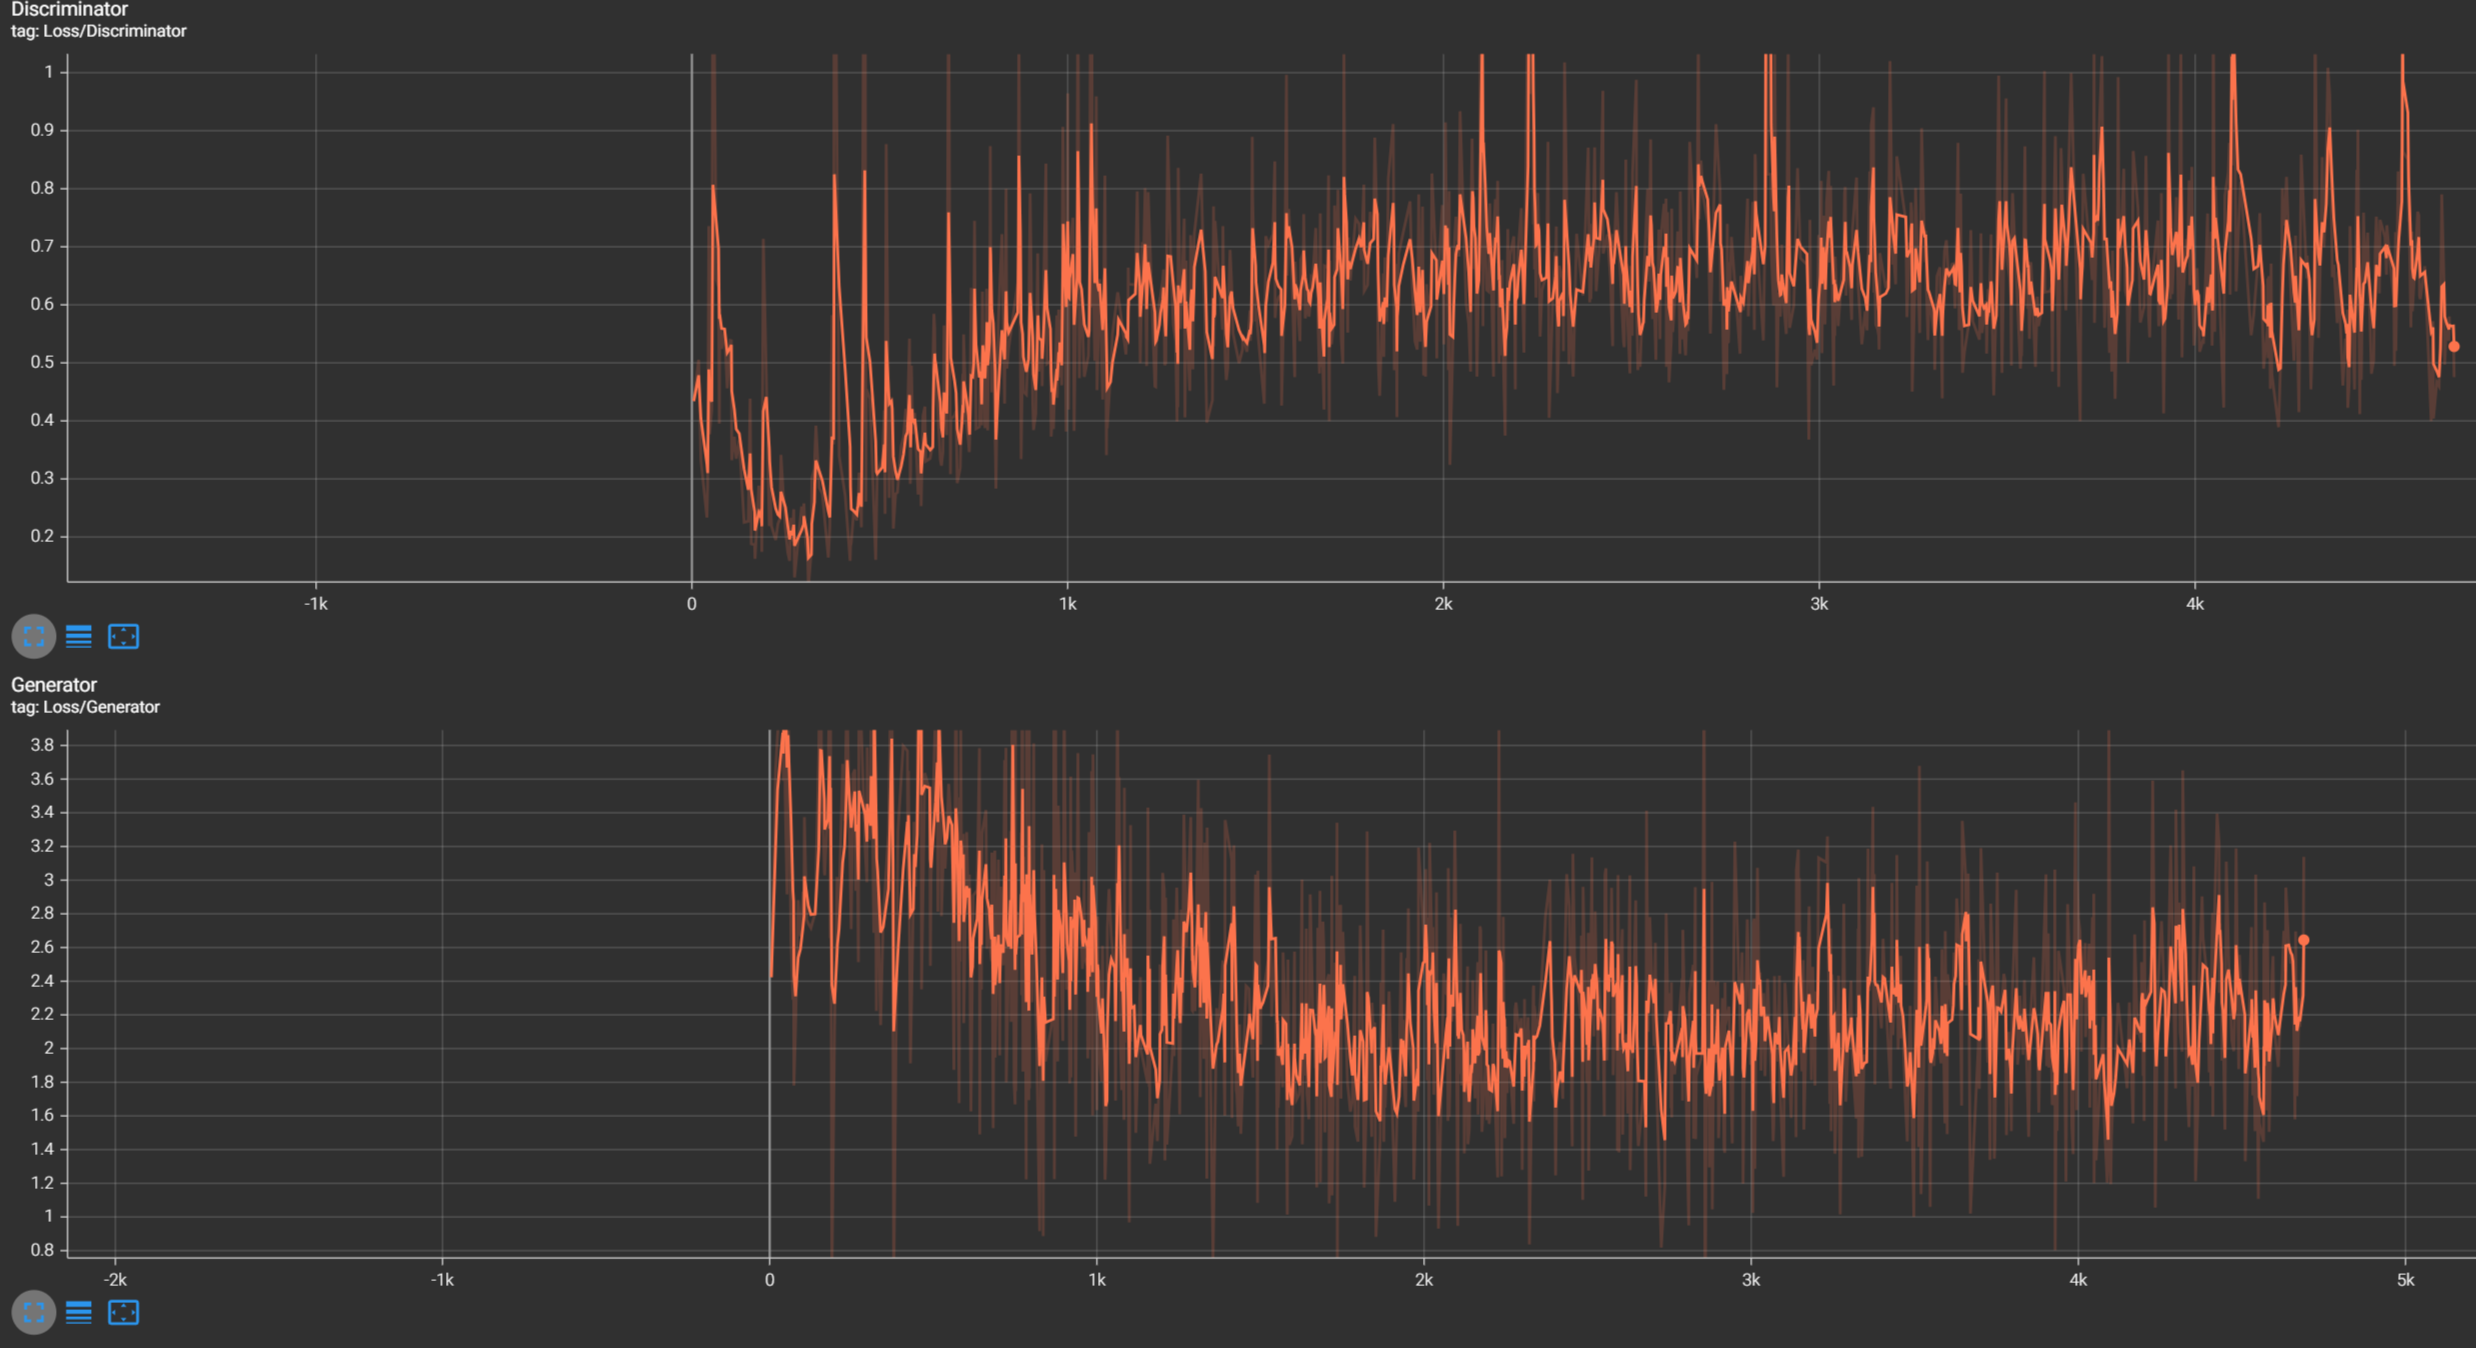

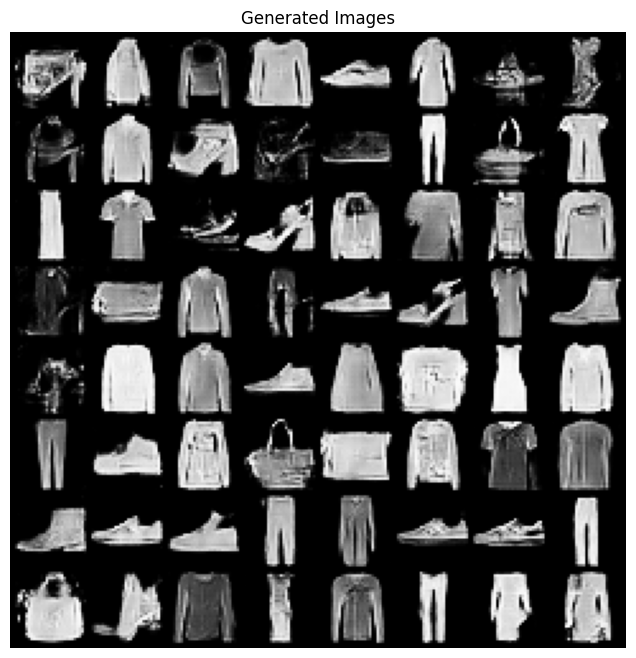

In [8]:
# Generate new samples
with torch.no_grad():
    fixed_noise = torch.randn(64, 100, 1, 1, device=device)
    generated_images = G(fixed_noise).detach().cpu()

# Visualize the generated samples
img_grid = torchvision.utils.make_grid(generated_images, padding=2, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
plt.title("Generated Images")
plt.axis('off')
plt.show()